In [46]:
using OptimalTransportDataIntegration
using Distributions
using DocStringExtensions
using Parameters
using Printf
using DataFrames
using Flux
using Plots

In [47]:
params = DataParameters(nA = 1000,
    nB = 1000,
    mA = [0.0],
    mB = [4.0],
    covA = ones(1,1),
    covB = ones(1,1),
    aA = [1.0],
    aB = [1.0],
    r2 = 0.9)
 
rng = ContinuousDataGenerator(params; scenario = 2)
data = generate(rng)

┌ Info: Categories in YA OrderedCollections.OrderedDict(1 => 263, 2 => 269, 3 => 217, 4 => 251)
└ @ OptimalTransportDataIntegration c:\Users\vgares\Documents\GitHub\OptimalTransportDataIntegration.jl\src\generate_continuous_data.jl:124
┌ Info: Categories in ZA OrderedCollections.OrderedDict(1 => 352, 2 => 335, 3 => 313)
└ @ OptimalTransportDataIntegration c:\Users\vgares\Documents\GitHub\OptimalTransportDataIntegration.jl\src\generate_continuous_data.jl:125
┌ Info: Categories in YB OrderedCollections.OrderedDict(1 => 248, 2 => 262, 3 => 258, 4 => 232)
└ @ OptimalTransportDataIntegration c:\Users\vgares\Documents\GitHub\OptimalTransportDataIntegration.jl\src\generate_continuous_data.jl:126
┌ Info: Categories in ZB OrderedCollections.OrderedDict(1 => 328, 2 => 366, 3 => 306)
└ @ OptimalTransportDataIntegration c:\Users\vgares\Documents\GitHub\OptimalTransportDataIntegration.jl\src\generate_continuous_data.jl:127


Row,X1,Y,Z,database
,Float64,Int64,Int64,Int64
1,-0.0429876,2,1,1
2,0.322238,3,2,1
3,0.916817,4,3,1
4,1.07351,4,3,1
5,0.217659,2,2,1
6,-0.743868,2,1,1
7,0.702323,3,3,1
8,2.39674,4,3,1
9,-0.850593,1,1,1


In [48]:
dba = subset(data, :database => ByRow(==(1)))
dbb = subset(data, :database => ByRow(==(2)))


cols = names(dba, r"^X")   

XA = transpose(Matrix(dba[:, cols]))
XB = transpose(Matrix(dbb[:, cols]))

XAi = round.(XA)
XBj = round.(XB)

1×1000 Matrix{Float64}:
 5.0  3.0  4.0  5.0  5.0  4.0  5.0  5.0  …  5.0  4.0  5.0  4.0  5.0  2.0  4.0

In [117]:
XA
XB

1×10 transpose(::Matrix{Float64}) with eltype Float64:
 2.94438  4.66342  4.1699  2.81765  …  4.72449  5.46386  2.99034  4.40834

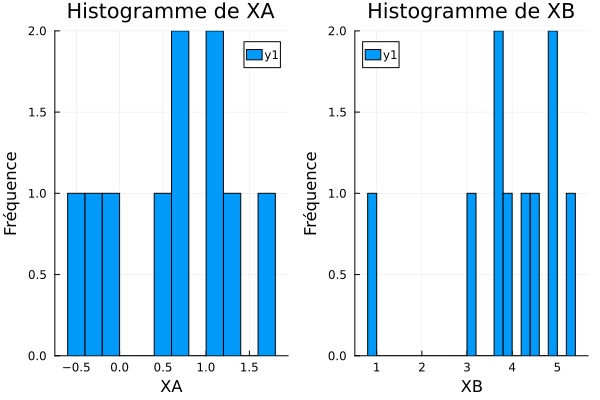

In [16]:
plot(
    histogram(vec(XA), bins=20, xlabel="XA", ylabel="Fréquence", title="Histogramme de XA"),
    histogram(vec(XB), bins=20, xlabel="XB", ylabel="Fréquence", title="Histogramme de XB"),
    layout = (1,2)   # 1 ligne, 2 colonnes
)


In [49]:
Ylevels = 1:4
Zlevels = 1:3
YA = Flux.onehotbatch(dba.Y, Ylevels)
ZB = Flux.onehotbatch(dbb.Z, Zlevels)



3×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  1  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  1
 1  ⋅  ⋅  1  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  1     1  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

In [18]:
show(dba.Y)
show(YA)

[4, 4, 4, 4, 2, 1, 4, 4, 4, 4]Bool[0 0 0 0 0 1 0 0 0 0; 0 0 0 0 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 1 1 1 1 0 0 1 1 1 1]

In [19]:
show(dbb.Z)
show(ZB)

[1, 2, 1, 2, 2, 3, 3, 2, 2, 1]Bool[1 0 1 0 0 0 0 0 0 1; 0 1 0 1 1 0 0 1 1 0; 0 0 0 0 0 1 1 0 0 0]

In [50]:
using Distances
nA = size(dba, 1)
nB = size(dbb, 1)

wa = ones(nA) ./ nA
wb = ones(nB) ./ nB

C0 = pairwise(Euclidean(), XA, XB, dims = 2)

C = C0 #./ maximum(C0)
C2=C.^2
display(C)
display(wa)
display(wb)

1000×1000 Matrix{Float64}:
 5.18707  3.48737  4.05077  5.40296  …  3.98224  4.70317  2.54045   4.27595
 4.82184  3.12214  3.68554  5.03773     3.61701  4.33794  2.17522   3.91072
 4.22726  2.52756  3.09097  4.44315     3.02243  3.74336  1.58064   3.31614
 4.07057  2.37087  2.93427  4.28646     2.86574  3.58667  1.42395   3.15944
 4.92642  3.22672  3.79012  5.14231     3.72159  4.44252  2.2798    4.0153
 5.88795  4.18825  4.75165  6.10384  …  4.68312  5.40405  3.24133   4.97683
 4.44176  2.74206  3.30546  4.65765     3.23693  3.95786  1.79514   3.53064
 2.74734  1.04764  1.61105  2.96323     1.54252  2.26344  0.100725  1.83622
 5.99467  4.29497  4.85837  6.21056     4.78984  5.51077  3.34805   5.08355
 6.23182  4.53212  5.09552  6.44771     5.02699  5.74792  3.5852    5.32069
 ⋮                                   ⋱                              
 3.68189  1.98219  2.54559  3.89778     2.47706  3.19799  1.03527   2.77077
 4.65167  2.95197  3.51537  4.86756     3.44684  4.16777  2.00505   3

1000-element Vector{Float64}:
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 ⋮
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001

1000-element Vector{Float64}:
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 ⋮
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001
 0.001

In [51]:
using PythonOT

reg = 0.0
reg_m1 = 0.0
reg_m2 = 0.0
G = ones(length(wa), length(wb))

#if reg > 0
#        G .= PythonOT.mm_unbalanced(wa, wb, C, (reg_m1, reg_m2); reg = reg, div = "kl")
#else
G .= PythonOT.emd(wa, wb, C2)
#end
show(size(ZB))
show(size(G'))
show(size(YA))
ZApred =  nA .* ZB * G'
YBpred =nB .* YA * G

(3, 1000)(1000, 1000)(4, 1000)

4×1000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0     1.0  1.0  0.0  0.0  1.0  0.0  0.0

In [33]:
display(XAi)
display(sort(vec(XAi)))
io = sortperm(vec(XAi))
display(sort(vec(YA[io])))
display(sort(vec(dba.Z[io])))
display(io)
display(sort(vec(XBj)))
jo = sortperm(vec(XBj)) 
display(jo)
display(sort(vec(ZB[io])))
display(sort(vec(dbb.Y[io])))
A = G[io,:]
display(A)
B=A[:,jo]
display(B)

1×10 Matrix{Float64}:
 1.0  1.0  1.0  2.0  -0.0  -1.0  1.0  0.0  -0.0  1.0

10-element Vector{Float64}:
 -1.0
 -0.0
 -0.0
  0.0
  1.0
  1.0
  1.0
  1.0
  1.0
  2.0

10-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 1
 1

10-element Vector{Int64}:
 1
 1
 3
 3
 3
 3
 3
 3
 3
 3

10-element Vector{Int64}:
  6
  5
  9
  8
  1
  2
  3
  7
 10
  4

10-element Vector{Float64}:
 1.0
 3.0
 4.0
 4.0
 4.0
 4.0
 5.0
 5.0
 5.0
 5.0

10-element Vector{Int64}:
  3
 10
  1
  4
  5
  9
  2
  6
  7
  8

10-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 1
 1
 1

10-element Vector{Int64}:
 1
 1
 2
 2
 3
 3
 3
 3
 4
 4

10×10 Matrix{Float64}:
 0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1
 0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
 0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0
 0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0

10×10 Matrix{Float64}:
 0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1
 0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0

In [23]:
display(XBj)

1×10 Matrix{Float64}:
 4.0  5.0  1.0  4.0  4.0  5.0  5.0  5.0  4.0  3.0

In [24]:
pos_idx = findall(x -> x > 0, G)
display(pos_idx)

10-element Vector{CartesianIndex{2}}:
 CartesianIndex(7, 1)
 CartesianIndex(4, 2)
 CartesianIndex(1, 3)
 CartesianIndex(9, 4)
 CartesianIndex(8, 5)
 CartesianIndex(5, 6)
 CartesianIndex(3, 7)
 CartesianIndex(2, 8)
 CartesianIndex(10, 9)
 CartesianIndex(6, 10)

In [25]:
XAv=vec(XA)
XBv=vec(XB)
show(pos_idx[1])
show(XAv[pos_idx[1][1]])
show(XBv[pos_idx[1][2]])

show(XAv[pos_idx[2][1]])
show(XBv[pos_idx[2][2]])


CartesianIndex(7, 1)1.15670482330836683.82771596009122561.76858555099719374.833137764840002

In [45]:
using Flux
display(ZB)
display(dbb.Z)
display(G)
show(Flux.onecold(ZApred))
show(accuracy(Flux.onecold(ZApred), dba.Z))


3×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  1  1  ⋅  ⋅  ⋅  1  ⋅  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     1  ⋅  1  1  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅

1000-element Vector{Int64}:
 3
 1
 1
 1
 2
 2
 2
 1
 2
 1
 ⋮
 2
 3
 2
 3
 3
 2
 2
 1
 1

1000×1000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

[3, 2, 1, 1, 3, 3, 1, 3, 2, 1, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 3, 3, 3, 1, 2, 2, 3, 1, 3, 1, 3, 2, 1, 2, 2, 2, 2, 1, 2, 3, 3, 2, 3, 1, 2, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 2, 1, 3, 2, 1, 1, 3, 2, 1, 3, 2, 3, 1, 2, 2, 3, 2, 1, 2, 2, 3, 1, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 2, 3, 3, 3, 1, 3, 2, 3, 3, 1, 2, 3, 2, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3, 3, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 3, 3, 2, 3, 2, 1, 2, 1, 1, 3, 2, 1, 2, 3, 3, 2, 3, 3, 1, 2, 2, 3, 2, 3, 1, 2, 2, 1, 3, 2, 3, 2, 2, 3, 2, 1, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 1, 3, 1, 1, 2, 2, 3, 2, 1, 1, 3, 1, 2, 2, 1, 3, 3, 3, 3, 1, 2, 3, 2, 3, 1, 1, 3, 3, 1, 2, 1, 3, 1, 3, 2, 3, 2, 1, 3, 2, 3, 1, 2, 1, 3, 3, 3, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 1, 3, 1, 2, 1, 3, 2, 3, 3, 1, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 3, 1, 1, 3, 1, 3, 2, 2, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1, 3, 1, 2, 2, 2, 1, 3, 2, 3, 2, 3, 3, 3, 3, 1, 2, 3, 1, 1, 1, 1, 3, 3, 3, 

In [53]:
show(accuracy(Flux.onecold(ZApred), dba.Z))
show(accuracy(Flux.onecold(YBpred), dbb.Y))

0.7360.641

In [27]:
display(G)
display(G')
display(dbb.Z)
display(dba.Z)

10×10 Matrix{Float64}:
 0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1
 0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0

10×10 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
 0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1
 0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0

10-element Vector{Int64}:
 1
 2
 1
 2
 2
 3
 3
 2
 2
 1

10-element Vector{Int64}:
 3
 3
 3
 3
 1
 1
 3
 3
 3
 3